# Is healthy food for rich people? A data story about nutrition and wealth

Our aim is to explore the relations that exist between the social and economic status of the French population and the quality of the food that is available. 

Indeed, we start from a point where we believe there is a correlation between obesity and socio-economic level: poor people tend to be more overweight than their richer counterparts. Moreover, obesity has been linked with the consumption of food items that have high rates of sugar, fat and energy.

We wish to explore a possible *intermediate link* between obesity and socio-economic level: the quality of the *available* food. 

Our dataframe includes labelled products, their nutritional information, a few nutritional scores and the cities where these products are sold. We have coupled this data with economical and social data from French cities in order to obtain a clean dataframe containing for each row:
- a product identifier
- its nutritional information
- the city where it is sold (if sold in several cities, the row is duplicated)
- the median revenue, mean revenue, poverty rate and other economic features relative to the city

In order to perform our analysis, we have proceeded in several steps:

1. Exploration and data cleaning

2. Exploration of the distribution of the nutrition grades at each geographical level for the richest and poorest zone

3. Distribution of the products frequency according to their nutrition grade

4. Implementation of two additional custom nutrition scores

5. Dimensionality reduction

6. Data aggregation according to a certain geographical level (city, arrondissement, department or region)

7. Attempt at clustering

8. Correlation exploration

9. Geographic visualisation

In [1]:
import findspark
import os
findspark.init(os.environ['SPARK_HOME'])

import folium
from IPython.core.display import display, HTML
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pyspark.sql import *
from pyspark.sql.functions import *
import re
import scipy as sp
from scipy import stats
from scipy import sparse
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import random
from branca.colormap import LinearColormap
from folium.folium import color_brewer, StepColormap, GeoJson, TopoJson
import seaborn as sns

%matplotlib inline

spark = SparkSession.builder.getOrCreate()

# 1. Exploration and cleaning

We first handle the nutrition-related data.

In [ ]:
food_facts = spark.read.csv('../data/raw/en.openfoodfacts.org.products.csv', header=True, sep="\t")
food_facts.registerTempTable('food_facts')

In [ ]:
food_facts.printSchema()

## A. First exploration of the data

In [ ]:
number_of_products = food_facts.count()
print("We have {} products in our dataframe.".format(number_of_products))

In [ ]:
print("Number of distinct city tags without france: {}".format(
    food_facts.select('cities_tags').filter('cities_tags NOT LIKE "%france%"')
    .distinct().count())
)
print("Number of distinct city tags : {}".format(
    food_facts.select('cities_tags').distinct().count())
)

In [ ]:
print("Number of distinct purchase places without france in the name: {}".format(
    food_facts.select('purchase_places').filter('LOWER(purchase_places) NOT LIKE "%france%"')
    .distinct().count()))
print("Number of distinct purchase places : {}".format(
    food_facts.select('purchase_places').distinct().count()))

In [ ]:
print("Number of manufacturing places without france in the name: {}".format(
    food_facts.select('manufacturing_places_tags')
              .filter('LOWER(manufacturing_places_tags) NOT LIKE "%france%"')
              .distinct().count())
)
print("Number of manufacturing places : {}".format(
    food_facts.select('manufacturing_places_tags').distinct().count())
)

It seems more interesting to make an analysis focused on the French situation rather than the situation in the US.

In [ ]:
food_facts.select('generic_name').filter('generic_name IS NOT NULL') \
    .distinct().toPandas().head()

We'll probably have to filter out the names that are not present in French.

In [ ]:
nutrition_grades = food_facts.select(
    'nutrition_grade_fr', 'nutrition_grade_uk', 'code', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g'
    ).filter('nutrition_grade_fr IS NOT NULL OR nutrition_grade_uk IS NOT NULL OR `nutrition-score-uk_100g` IS NOT NULL OR `nutrition-score-fr_100g` IS NOT NULL').toPandas()
print("""Total number of products for which we have nutrition informations: 
{}"""
      .format(nutrition_grades.count())
)
print("Proportion of products for which we have nutrition informations: {ratio:.3%}"
      .format(ratio=(nutrition_grades['code'].count()/number_of_products))
)
print("Description of the table: ")
nutrition_grades.describe()

We see that `nutrition_grade_uk` is useless.

## B. Data cleaning

### *Food*

In [ ]:
# select only the columns we plan to use
food_dataframe = food_facts.select('generic_name',
                                   'code',
                                   'nutrition_grade_fr',
                                   'nutrition-score-fr_100g',
                                   'nutrition-score-uk_100g',
                                   'serving_size',
                                   'energy_100g',
                                   'energy-from-fat_100g', 
                                   'trans-fat_100g',
                                   'fat_100g',
                                   'saturated-fat_100g',
                                   'monounsaturated-fat_100g',
                                   'polyunsaturated-fat_100g',
                                   'cholesterol_100g',
                                   'proteins_100g',
                                   'carbohydrates_100g', 
                                   'sugars_100g', 
                                   'fiber_100g',
                                   'fruits-vegetables-nuts_100g',
                                   'fruits-vegetables-nuts-estimate_100g',
                                   'glycemic-index_100g',
                                   'cities',
                                   'cities_tags',
                                   'purchase_places',
                                   'stores',
                                   'countries',
                                   'countries_tags')
# move to pandas for the rest of the analysis
food_dataframe = food_dataframe.toPandas()

We first remove all products that are not sold in France.

In [ ]:
food_dataframe = food_dataframe[np.logical_not(food_dataframe['countries_tags'].apply(
                                        lambda x: x is None or "france" not in x.lower())
               & food_dataframe['countries'].apply(lambda x: x is None or "france" not in x.lower())
               & food_dataframe['cities_tags'].apply(lambda x: x is None or "france" not in x.lower())
               & food_dataframe['cities'].apply(lambda x: x is None or "france" not in x.lower())
               & food_dataframe['purchase_places'].apply(lambda x: x is None or "france" not in x.lower())
               & food_dataframe['stores'].apply(lambda x: x is None or "france" not in x.lower()))]

Now, we want to check how many of our features have a significant amount of entries.

In [ ]:
total_rows = len(food_dataframe)
for col in food_dataframe.columns:
    none_values = np.count_nonzero(food_dataframe[col].apply(lambda x: x is None))
    not_none_percentage = (total_rows - none_values) / total_rows
    print('Rows that are **not** None in {col}: {p:.3%}'.format(col=col, p=not_none_percentage))

**Based on this, we will have to remove some rows:**

We remove the rows for which we have less than 10% of not None values.

- energy-from-fat_100g
- monounsaturated-fat_100g
- polyunsaturated-fat_100g
- cholesterol_100g
- trans-fat_100g
- fruits-vegetables-nuts_100g
- fruits-vegetables-nuts-estimate_100g
- glycemic-index_100g
- cities
- generic_name

Since we have the code of the product, we drop the generic_name attribute too.

We also need to drop all rows for which we have no information whatsoever (nutrition_grade, fat, saturated fat, sugars, proteins, fiber, carbohydrates, energy).

Finally, we need to drop all rows for which we have no information on the city where it is sold.

In [ ]:
# Drop the columns with too few values
food_dataframe = food_dataframe.drop(columns=['energy-from-fat_100g', 
                             'monounsaturated-fat_100g', 
                             'polyunsaturated-fat_100g',
                             'cholesterol_100g',
                             'trans-fat_100g',
                             'fruits-vegetables-nuts_100g',
                             'fruits-vegetables-nuts-estimate_100g',
                             'glycemic-index_100g',
                             'glycemic-index_100g',
                             'cities',
                             'generic_name'])

# Drop the rows with too little nutritional information
food_dataframe = food_dataframe[np.logical_not(food_dataframe['nutrition_grade_fr'].apply(lambda x: x is None)
                                               # we do not check the values of nutrition-score-fr_100g or
                                               # nutrition-score-uk_100g, because we know that they exists for exactly
                                               # the same rows as nutrition_grade_fr
                                               & food_dataframe['energy_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['fat_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['saturated-fat_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['carbohydrates_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['sugars_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['fiber_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['proteins_100g'].apply(lambda x: x is None)
                                              )
                               ]

# Drop the rows with no purchase place
food_dataframe = food_dataframe[food_dataframe['purchase_places'].apply(lambda x: x is not None)]

In [ ]:
food_dataframe.head()

In [ ]:
total_rows = len(food_dataframe)
for col in list(food_dataframe.columns):
    none_values = np.count_nonzero(food_dataframe[col].apply(lambda x: x is None))
    not_none_percentage = (total_rows - none_values) / total_rows
    print('Rows that are **not** None in {col}: {p:.3%}'.format(col=col, p=not_none_percentage))

We still have rows for which the city tag is none and the purchase place is very vague, like France or the US. We need to take care of those. We will do it by creating a matching between the Open Food Facts dataset and a dataset including all cities of France.

### *Cities*

In [ ]:
# The dataframe: 
# https://www.insee.fr/fr/statistiques/3126432
revenue_df = pd.read_excel("../data/raw/base-cc-filosofi-2014.xls", skiprows=[0,1,2,3])

# Drop rows that are not data and reset index
revenue_df.drop(0, inplace=True)
revenue_df.reset_index(inplace=True, drop=True)


# Drop useless columns
revenue_df = revenue_df.drop(columns=['Nombre de ménages fiscaux','Code géographique',
                                      'dont part des salaires, traitements ou chômage (%)',
                                      "dont part des revenus d'activités non salariées (%)",
                                      'dont part des prestations familiales (%)',
                                      'dont part des minima sociaux (%)',
                                      'dont part des prestations logement (%)',
                                      '1er décile du niveau de vie (€)',
                                      '9e décile du niveau de vie (€)',
                                      'Rapport inter-décile 9e décile/1er decile',
                                      'Part des ménages fiscaux imposés (%)'
                                     ]
                            )

# Translate the remaining columns to English
revenue_df = revenue_df.rename(columns={"ANNEE" : "Year",
                                        'Nombre de personnes dans les ménages fiscaux': "Household inhabitants", 
                                        'Médiane du niveau vie (€)': "Median revenue euros", 
                                        'Taux de pauvreté-Ensemble (%)' : "Total poverty rate (%)", 
                                        'Taux de pauvreté-moins de 30 ans (%)' : "Poverty rate (-30) (%)",
                                        'Taux de pauvreté-30 à 39 ans  (%)' : "Poverty rate (30-39) (%)",
                                        'Taux de pauvreté-40 à 49 ans (%)': "Poverty rate (40-49) (%)", 
                                        "Taux de pauvreté-50 à 59 ans (%)" :  "Poverty rate (50-59) (%)", 
                                        "Taux de pauvreté-60 à 74 ans (%)" :  "Poverty rate (60-74) (%)", 
                                        "Taux de pauvreté-75 ans ou plus (%)":  "Poverty rate (75+) (%)", 
                                        "Taux de pauvreté-propriétaires (%)" :  "Poverty rate (house owners) (%)", 
                                        "Taux de pauvreté-locataires (%)" :  "Poverty rate (tenants) (%)",
                                        "Part des revenus d'activité (%)" :  "Share of activity revenue (%)", 
                                        'Part des pensions, retraites et rentes (%)' :  "Share of retreat pension revenue (%)", 
                                        'Part des revenus du patrimoine et autres revenus (%)' :  "Share of heritage revenue and other (%)",  
                                        "Part de l'ensemble des prestations sociales (%)" :  "Share of social benefits revenue (%)", 
                                        'Part des impôts (%)' :  "Share of taxes (%)",
                                        'Libellé géographique' : "City name"
                                       }
                              )

In [ ]:
revenue_df.head()

In [ ]:
print("Total number of rows:", len(revenue_df))

In [ ]:
print("Total number of cities: ", len(list(set(revenue_df["City name"]))))

## C. Mapping cities - food products

In this section, we will try to find a mapping between a city as present in the OpenFoodFacts dataset, and a city as know by the INSEE.

In [ ]:
# Helper to remove the accents
import unicodedata as ud

def remove_accents(input_str):
    nkfd_form = ud.normalize('NFKD', str(input_str))
    return u"".join([c for c in nkfd_form if not ud.combining(c)])

First, let us remove the accents, lowercase everything, and replace apostrophes by carets

In [ ]:
revenue_df['City name'] = revenue_df['City name'].apply(lambda x: remove_accents(x.lower().replace("'", "-"))) 
revenue_df.head()

The tags for the cities (information present on the food items) are a list of comma separated tags, where each tag has the form: `city-name-department-name-france`, where `city-name` and `department-name` do not have accents and had their apostrophes and white spaces replaces by carets.

In [ ]:
# get the tags of the cities per food item:
# until now, the tags were a comma separated list of tags
# we first split them
cities_for_food = (food_dataframe['cities_tags'].str.split(',', expand=True)
                    # then we create one entry per couple (food item, city tag)
                    .stack()
                    # we remove the index, as we will need to keep the column containing the id of the food item
                    .reset_index()
                    # and we drop duplicates and unnecessary columns
                    .drop(columns='level_1').drop_duplicates())

We move back to spark, because pandas does not offer the functionalities we need.

In [ ]:
sdf_city_names = spark.createDataFrame(revenue_df['City name'].drop_duplicates().reset_index())
sdf_cities_for_food = spark.createDataFrame(cities_for_food)
sdf_cities_for_food.createTempView('cities_for_food')
sdf_city_names.createTempView('city_names')

# we join our two dataframes, explanation below
sdf_joined = spark.sql("""
SELECT city_names.index AS city_index, city_names.`City name` AS city_name, 
       aux.food_item_index, aux.city_tag_from_food_item
FROM city_names
JOIN (
    SELECT MAX(LENGTH(city_names.`City name`)) AS length_city_name, 
           cities_for_food.level_0 AS food_item_index, cities_for_food.`0` AS city_tag_from_food_item
    FROM cities_for_food
    JOIN city_names
    ON cities_for_food.`0` LIKE CONCAT(city_names.`City name`, '%')
    GROUP BY cities_for_food.level_0, cities_for_food.`0`
) AS aux
ON aux.city_tag_from_food_item LIKE CONCAT(city_names.`City name`, '%')
WHERE aux.length_city_name == LENGTH(city_names.`City name`)
""")

A city's tag seems to usually be 'city-s-name-department-name-country-name'.
A city's name is now 'city-s-name'.

Thus we can join on the condition: `city_s_tag LIKE city_s_name + '%'`.

Unfortunately, the city's name "Saint Alban", formatted as "saint-alban", will also match the tag "saint-alban-les-eaux", though these two cities maybe totally different and far away from one another.

Thus, we want to kep only the longest city's name matching the tag, hence:
```sql
SELECT MAX(LENGTH(city_names.`City name`)) AS length_city_name, 
           cities_for_food.level_0 AS food_item_index, cities_for_food.`0` AS city_tag_from_food_item
    FROM cities_for_food
    JOIN city_names
    ON cities_for_food.`0` LIKE CONCAT(city_names.`City name`, '%')
    GROUP BY cities_for_food.level_0, cities_for_food.`0`
```
returning the size of the longest matching city name.

We then have to re-do the same join and filter using the computed condition.

In [ ]:
# We write our dataframe to parquet, to be able to reuse it without needing to recompute everything
sdf_joined.write.mode('overwrite').parquet("../data/interim/sdf_joined_city_names.parquet")
# Now we still have to join our food items and our cities, using the mapping we managed to get above
# We switch back to pandas
pdf_joined = sdf_joined.toPandas()
pdf_joined.head()

In [ ]:
# We join our mapping with the food dataframe
food_df_for_join = pdf_joined.join(food_dataframe, on="food_item_index")
food_df_for_join.head()

In [ ]:
# We join again on the income dataframe
global_df = food_df_for_join.join(revenue_df, on="city_index")
# we can now drop the intermediary columns: city_name, and cities_tags
global_df.drop(columns=['cities_tags'], inplace=True)
global_df.head()

The nutrition grade being a string, we cannot use it as is. Thus we turn it into a numerical value.

In [ ]:
def grade_to_number(x):
    """Convert the nutrition_grade to a numeric representation
    
    Arguments:
    ----------
    x: string
        Nutrition grade to convert.

    Returns:
    --------
    numeric_representation: int
        Numeric representation of the nutrition grade.
    """
    if x == "a":
        return 1
    if x == "b":
        return 2
    if x == "c":
        return 3
    if x == "d":
        return 4
    if x == "e":
        return 5
    return 0
global_df['nutrition_grade_numeric'] = global_df['nutrition_grade_fr'].apply(grade_to_number).astype('int')

In [ ]:
global_df.to_csv("../data/interim/clean_food_and_cities.csv")

**DISCLAIMER:** Several French towns have the exact same name. Thus, we have a few errors in our mapping. As this situation concerns less than 1% of the towns, it shouldn't impact our analysis.

## D. Arrondissements

In order to visualize data, we need to make the correspondences between the cities that we have and their respective arrondissement. The arrondissement is the territorial subdivision of the French territory that comes after the Department. There are around 340 arrondissements in France. We thought this subdivision was small enough to show the differences across the French territory but large enough for it to be visible on a map. In the same step, we kept the information relative to the other administrative areas in France, namely the departments and regions.

In [ ]:
global_df = pd.read_csv('../data/interim/clean_food_and_cities.csv')

In [ ]:
# The new dataframe:
# https://www.insee.fr/fr/information/2028028
# Table d'appartenance géographique des communes au 1ᵉʳ janvier 2017
city_arr = pd.read_excel('../data/raw/table-appartenance-geo-communes-17.xls', skiprows=[0, 1, 2, 3])
city_arr.drop(0, inplace=True)
city_arr.reset_index(inplace=True, drop=True)

city_arr["city_name"] = city_arr['Libellé géographique'].apply(
    # Remove accents, lowercase, and replace spaces ad apostrophes by '-'
    lambda x: remove_accents(x.lower().replace("'", '-').replace(" ", "-"))
) 

# Drop useless columns
city_arr = city_arr.drop(columns=['Intercommunalité - Métropole', "Nature d'EPCI", "Zone d'emploi 2010", 
                       "Unité urbaine 2010", "Tranche d'unité urbaine 2014", 
                       "Tranche détaillée d'unité urbaine 2014", "Aire urbaine 2010", 
                       "Tranche d'aire urbaine 2014", "Bassin de vie 2012"]
             )
city_arr.rename(columns={'Libellé géographique' : 'City name'}, inplace=True)
city_arr.head()

To get a mapping to available geojson files for the administrative areas of France, we have to format our informations about the belonging of a city to an administrative area.

In [ ]:
# To match the geojson file we found, we have to format the code of our arrondissements
city_arr["custom_arrondissement_code"] = city_arr["Département"] + "00" + city_arr['Arrondissement'].astype('str').apply(lambda x: x[-1])
city_arr.head()

In [ ]:
city_arr.to_csv("../data/interim/city_region_arrondissement.csv")

In [ ]:
global_arrond = global_df.merge(city_arr, left_on="city_name", right_on="city_name", how='inner')
global_arrond.head()

Translating to English the columns and keeping only the relevant columns gives us this dataframe. 

In [ ]:
global_arrond = global_arrond.rename(columns={"Département" : "Department", "Région" : "Region", "City name_y": "City name"})
global_arrond = global_arrond[['food_item_index', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
                       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g', 
                       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g', 'sugars_100g', 
                       'fiber_100g', 'Median revenue euros', 'Total poverty rate (%)', 'Poverty rate (-30) (%)',
                       'Poverty rate (30-39) (%)', 'Poverty rate (40-49) (%)',
                       'Poverty rate (50-59) (%)', 'Poverty rate (60-74) (%)',
                       'Poverty rate (75+) (%)', 'Poverty rate (house owners) (%)',
                       'Poverty rate (tenants) (%)', 'Share of activity revenue (%)',
                       'Share of retreat pension revenue (%)',
                       'Share of heritage revenue and other (%)',
                       'Share of social benefits revenue (%)', 'Share of taxes (%)', 'City name', 
                       'Department', 'Region', 'custom_arrondissement_code', 'city_name', 'city_tag_from_food_item']]
global_arrond.head()

In [ ]:
global_arrond.to_csv("../data/interim/clean_food_cities_arrond.csv")

# Analysis of our data

Now that the data cleaning is done, and in order to analyse the data, we need to proceed with the next steps: 

2. Exploration of the distribution of the nutrition grades at each geographical level for the richest and poorest zone

3. Distribution of the products frequency according to their nutrition grade

4. Implementation of two additional custom nutrition scores

5. Dimensionality reduction

6. Data aggregation according to a certain geographical level (city, arrondissement, department or region)

7. Attempt at clustering

8. Correlation exploration

9. Geographic visualisation

In [142]:
dataframe = pd.read_csv('../data/processed/clean_food_cities_arrond.csv', low_memory=False)
dataframe = dataframe.drop(columns=['Unnamed: 0'])
dataframe.rename(columns={"City name": "City", "custom_arrondissement_code": "Arrondissement"}, inplace=True)
dataframe.head()

,food_item_index,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,...,Poverty rate (tenants) (%),Share of activity revenue (%),Share of retreat pension revenue (%),Share of heritage revenue and other (%),Share of social benefits revenue (%),Share of taxes (%),City,Department,Region,Arrondissement
0,359180,14.0,19.0,4,150 g,1243.0,24.0,17.0,19.0,1.3,...,29.609475,65.9,31.2,11.1,7.1,-15.3,Belley,01,84,01001
1,359153,15.0,20.0,4,NaN,1402.0,30.0,19.0,15.0,1.3,...,29.609475,65.9,31.2,11.1,7.1,-15.3,Belley,01,84,01001
2,359177,15.0,20.0,4,NaN,1435.0,31.0,21.0,15.0,1.0,...,29.609475,65.9,31.2,11.1,7.1,-15.3,Belley,01,84,01001
3,359157,14.0,19.0,4,NaN,1238.0,24.0,18.0,19.0,1.0,...,29.609475,65.9,31.2,11.1,7.1,-15.3,Belley,01,84,01001
4,359155,15.0,20.0,4,NaN,1435.0,31.0,21.0,15.0,1.0,...,29.609475,65.9,31.2,11.1,7.1,-15.3,Belley,01,84,01001


# 2. Distribution of the nutrition grades at each geographical level for the richest and poorest zone

In [45]:
def analyse_for_area(df, area_column, area_name):
    """Display the distribution of the numeric nutrition grade for the richest and poorest area
    
    Arguments:
    ----------
    df: pandas.DataFrame
        The dataframe containing the needed information.
    area_column: string
        Name of the column containing the information about the area.
    area_name: string
        Name of the area.
    """
    revenue = df.groupby(area_column).mean().sort_values(by=['Median revenue euros'], ascending=False)
    rich = revenue.iloc[[0]]
    rich.reset_index(inplace=True)
    poor = revenue.iloc[[-1]]
    poor.reset_index(inplace=True)
    
    departments = [list(rich[area_column].values)[0], list(poor[area_column].values)[0]]
    list_dummy_grades = ['nutrition_grade_numeric_0', 'nutrition_grade_numeric_1',
                     'nutrition_grade_numeric_2', 'nutrition_grade_numeric_3',
                     'nutrition_grade_numeric_4', 'nutrition_grade_numeric_5']
    
    dummies = pd.get_dummies(df, columns=['nutrition_grade_numeric']).groupby(area_column).sum()
    dummies.reset_index(inplace=True)
    dummies = dummies[dummies[area_column].apply(lambda x: x in departments)][list_dummy_grades]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle("Distribution of the nutrition grades' frequencies for the richest and the poorest {}".format(area_name),
                 y=1.08, fontweight="bold")

    sns.barplot(x=[0, 1, 2, 3, 4, 5], y=dummies.iloc[0].values, ax=ax1)
    sns.barplot(x=[0, 1, 2, 3, 4, 5], y=dummies.iloc[1].values, ax=ax2)
    ax1.set_xlabel('Nutrition grade')
    ax1.set_ylabel('Frequency')
    ax2.set_xlabel('Nutrition grade')
    ax2.set_ylabel('Frequency')
    ax1.set_title("Richest {}".format(area_name))
    ax2.set_title("Poorest {}".format(area_name))

    plt.show()

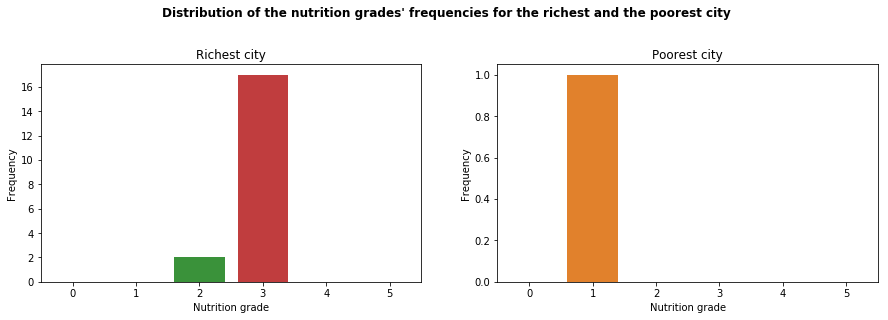

In [46]:
analyse_for_area(dataframe, 'City', 'city')

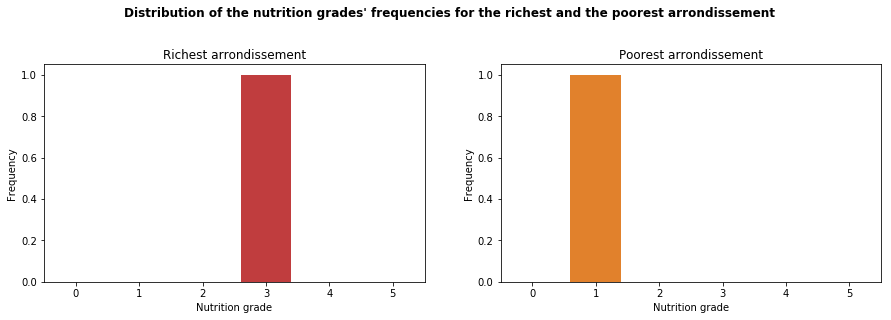

In [47]:
analyse_for_area(dataframe, 'Arrondissement', 'arrondissement')

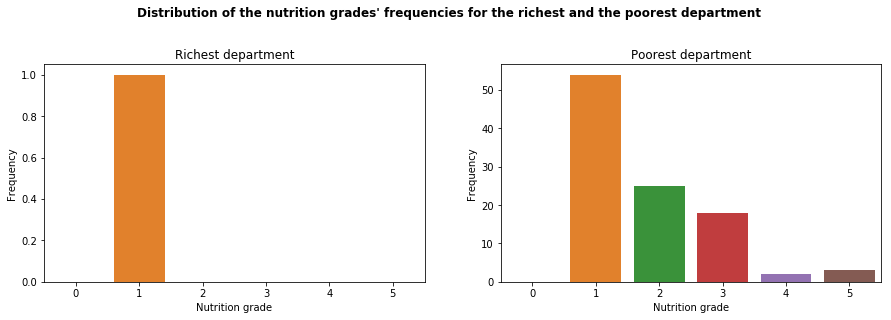

In [48]:
analyse_for_area(dataframe, 'Department', 'department')

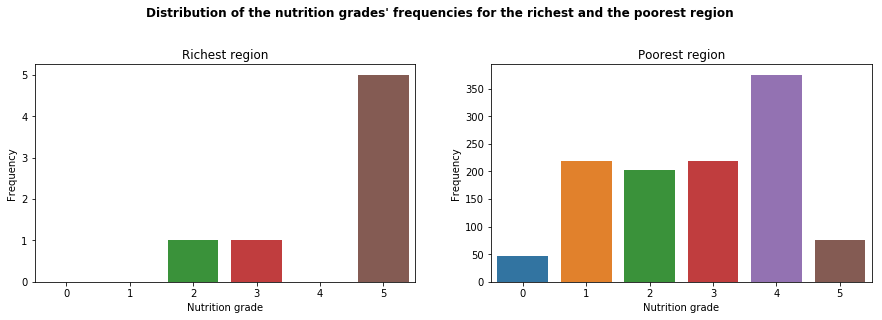

In [49]:
analyse_for_area(dataframe, 'Region', 'region')

We see that rich and poor areas can have very different distribution of the healthiness of the available products.
However, we cannot infer a correlation from only two areas.

Also, we see that the number of products varies a lot between areas. This was expected, as the products are entered by the users of OpenFoodFacts.

# 3. Implementation of custom nutrition scores

We introduce two more nutrition scores: calory density (the calories per serving) and calory deviation.

The *calory deviation* is computed according to the nutritional standards that among the calories we consume in a day, $21\%$ should come from proteins, $53\%$ from carbohydrates and $26\%$ from fat. We then compute a deviation from this standard for each product. 

* In the first case (calory density), the metric describes how largely a product is packed with calories. Since obesity is often linked with the density in calories of the ingested food items, this metric might be useful.

* In the second case (calory deviation), we aim at observing whether the products follow a healthy calory distribution. This metric would show us if a certain region has bad nutrition habits with respect to the ratios of nutriments they should eat.

In [143]:
# We consider only the energy per 100g and the serving size
cals = dataframe[['energy_100g', 'serving_size']]
# We drop nan values, and serving sizes that are not relevant
cals = cals.dropna()
cals = cals.drop(cals[cals['serving_size'].str.contains("mg")].index)
cals = cals.drop(cals[cals['serving_size'].str.contains('oeuf')].index)
cals = cals.drop(cals[cals['serving_size'].str.contains('Deux tranches g')].index)
# We keep only the number of units of the usual measure unit for the product
cal = cals['serving_size'].str.replace('.*?(?P<number>[0-9.,]+)\s*(G|g|f|ml|mL).*', '\\g<number>')
cal = cal.str.replace('.*?(?P<number>[0-9.,]+)\s*(cl|cL).*', '\\g<number>0')
cal = cal.str.replace('.*?(?P<number>[0-9.,]+)\s*(Kg|L|l).*', '\\g<number>000')
# We remove values that are composed only of letters
cal = cal.str.replace('[^0-9]+', '')
cal = cal.replace('', np.nan)
cal = cal.dropna()
# We cast everything to float
cal = cal.str.replace(",", ".").astype('float')
cals.serving_size = cal
# and reinsert it in our dataframe
dataframe.loc[:, 'serving_size'] = cal

cal_density = cals.serving_size * cals.energy_100g / 100

**Note**

Proteins bring 4 calories per gram, and should constitue 21% of our calories.

Carbohydrates also bring 4 calories per gram, and should constitue 53% of our calories.

Fat brings 9 calories per gram, and should constitue the remaining 26% of our calories.

Hence the computations below:

In [144]:
# Energy has to be divided by 4.184 to convert from kiloJoules to kilocalories
energy_in_kcal_100g = dataframe.energy_100g / 4.184
cal_deviation = ((dataframe.fat_100g * 9 / energy_in_kcal_100g - 0.26)**2 + 
                (dataframe.carbohydrates_100g * 4 / energy_in_kcal_100g - 0.53)**2 +
                (dataframe.proteins_100g * 4 / energy_in_kcal_100g - 0.21)**2)/3
# We remove unknown and infinite values
cal_deviation.replace(np.infty, np.nan, inplace=True)
cal_deviation.dropna(inplace=True)
cal_deviation.describe()

count    35169.000000
mean         7.199594
std        623.874225
min          0.000044
25%          0.016664
50%          0.069864
75%          0.158160
max      58205.149533
dtype: float64

In [145]:
# We insert our columns in our dataframe
dataframe.loc[:, 'cal_density'] = cal_density
dataframe.loc[:, 'cal_deviation'] = cal_deviation
dataframe.head()

,food_item_index,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,...,Share of retreat pension revenue (%),Share of heritage revenue and other (%),Share of social benefits revenue (%),Share of taxes (%),City,Department,Region,Arrondissement,cal_density,cal_deviation
0,359180,14.0,19.0,4,150.0,1243.0,24.0,17.0,19.0,1.3,...,31.2,11.1,7.1,-15.3,Belley,01,84,01001,1864.5,0.160968
1,359153,15.0,20.0,4,NaN,1402.0,30.0,19.0,15.0,1.3,...,31.2,11.1,7.1,-15.3,Belley,01,84,01001,NaN,0.187835
2,359177,15.0,20.0,4,NaN,1435.0,31.0,21.0,15.0,1.0,...,31.2,11.1,7.1,-15.3,Belley,01,84,01001,NaN,0.192079
3,359157,14.0,19.0,4,NaN,1238.0,24.0,18.0,19.0,1.0,...,31.2,11.1,7.1,-15.3,Belley,01,84,01001,NaN,0.163284
4,359155,15.0,20.0,4,NaN,1435.0,31.0,21.0,15.0,1.0,...,31.2,11.1,7.1,-15.3,Belley,01,84,01001,NaN,0.192079


# 4. Distribution of the products per nutrition grade and per median revenue of the city where it is sold

* Nutrition grade has integer values between 1 and 5, 1 indicating healthy food items and 5 describing unhealthy items.

* Nutrition score (UK or Fr.) has values between -15 and 40. -15 indicates a healthy food item, 40 indicates an unhealthy food item. 

The correspondence between the two of them for solid foods is:

* Nutrition grade = 1 : nutrition score $\in [-15, : -1]$
* Nutrition grade = 2 : nutrition score $\in [0, 2]$
* Nutrition grade = 3 : nutrition score $\in [3, 10]$
* Nutrition grade = 4 : nutrition score $\in [11, 18]$
* Nutrition grade = 5 : nutrition score $\in [19, 40]$

The correspondence between the two of them for beverages is:

* Nutrition grade = 1 : Water
* Nutrition grade = 2 : nutrition score $\in [-15, 1]$
* Nutrition grade = 3 : nutrition score $\in [2, 5]$
* Nutrition grade = 4 : nutrition score $\in [6, 9]$
* Nutrition grade = 5 : nutrition score $\in [10, 40]$

https://fr.openfoodfacts.org/nutriscore

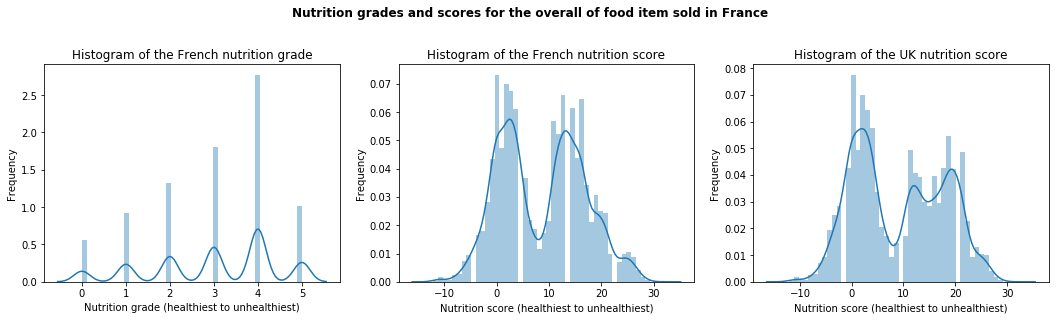

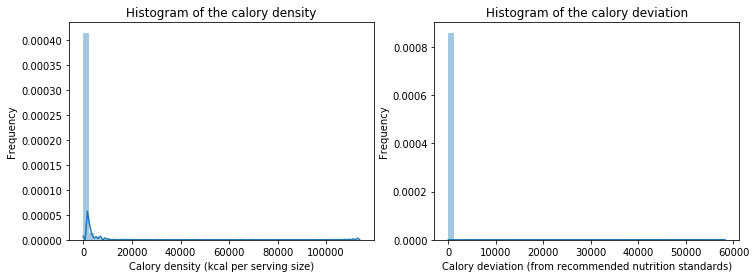

In [146]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
f.suptitle("Nutrition grades and scores for the overall of food item sold in France", 
           y=1.08, fontweight="bold")
sns.distplot(dataframe['nutrition_grade_numeric'].dropna().values, ax=ax1, norm_hist=True)
ax1.set_title("Histogram of the French nutrition grade")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Nutrition grade (healthiest to unhealthiest)")

sns.distplot(dataframe['nutrition-score-fr_100g'].dropna().values, ax=ax2)
ax2.set_title("Histogram of the French nutrition score")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Nutrition score (healthiest to unhealthiest)")

sns.distplot(dataframe['nutrition-score-uk_100g'].dropna().values, ax=ax3)
ax3.set_title("Histogram of the UK nutrition score")
ax3.set_ylabel("Frequency")
ax3.set_xlabel("Nutrition score (healthiest to unhealthiest)")

f.savefig("../docs/img/portfolio/nutrigrade_hist.pdf")
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(dataframe['cal_density'].dropna().values, ax=ax1, norm_hist=True)
ax1.set_title("Histogram of the calory density")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Calory density (kcal per serving size)")

sns.distplot(dataframe['cal_deviation'].dropna().values, ax=ax2)
ax2.set_title("Histogram of the calory deviation")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Calory deviation (from recommended nutrition standards)")

f.savefig("../docs/img/portfolio/nutrigrade_hist2.pdf")
plt.show()


*Reminder: `0` is equivalent to no data for Fr. nutrition grade.*

When we look at the nutrition grade histogram, we see that most of the products are labeled with a `3` or higher, which indicates that healthy products are rare in comparison. 

When looking at the nutrition score histograms, we can see two peaks. One where the products are around 0 (i.e. nutrition grade of 2) and the other one with products around 15 (nutrition grade of 4). Most products are however well above 0 (i.e. nutrition grade of 2 or higher), hence the lack of healthy products is reinforced. 

Let's now look at the distribution of the median revenue of the cities where the products are sold.

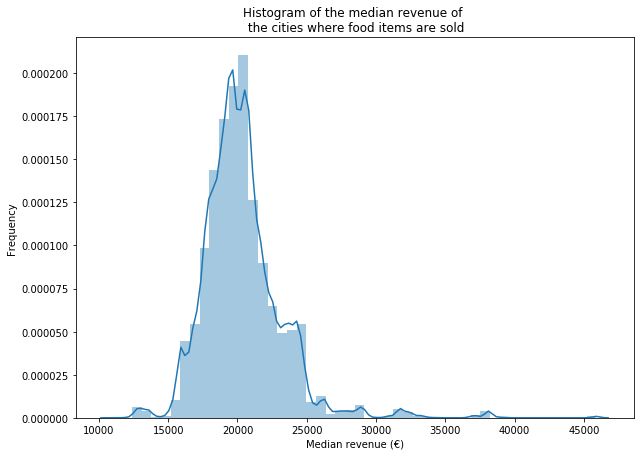

In [147]:
f = plt.figure(figsize=(10, 7))
sns.distplot(dataframe['Median revenue euros'].dropna().values, norm_hist=False)
plt.xlabel('Median revenue (€)')
plt.ylabel('Frequency')
plt.title('Histogram of the median revenue of \n the cities where food items are sold')
f.savefig("../docs/img/portfolio/revenue_hist.pdf")
plt.show()

We can see that most of our products are sold in cities where the median revenue is around 20 000 €. This histogram is a tight gaussian that shows that we do not have many values for cities where the median revenue is lower than 15 000 € a year, nor for cities having a median yearly revenue of more than 25 000 €. This corresponds in France to the **lower middle class.**

We can already see that this is going to be a problem when we analyse our data. Indeed, having most of our products belonging to a moderate revenue biases our anaylisis and will make us more likely to remove outliers that are in extreme ranges of revenue.

# 5. Dimensionality reduction

The aim of this section is to use Mutual Information in order to decide which columns in our dataframe are worth keeping. Indeed, we have numerous poverty markers and five different nutrition scores. We wish to see if among these categories, some columns overlap so much that we can exclude them from our analysis. 

We have some non-numeric columns in our dataframe that we cannot use as is for our dimensionality reduction. Luckily, these columns are all the geographical ones (region, city, arrondissement and department). We do not wish to eliminate either of those columns because they are useful for aggregation and visualization. 

Hence, the numeric columns selected below are the numerical attributes that we are going to compare to each other using Mutual Information and they describe the nutritional features of the products and the economic characteristics of the cities where they are sold. 

## A. Checking which columns have the most information

Once again, we try to find the columns for which we are lacking information: we find that it is wise to avoid using them, even before we try to compute the Mutual Information among them.

In [148]:
numeric_cols = ['food_item_index', 'nutrition-score-fr_100g', 
                'nutrition-score-uk_100g','nutrition_grade_numeric', 'serving_size', 'energy_100g', 
                'fat_100g','saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g','sugars_100g', 
                'fiber_100g', 'Median revenue euros','Total poverty rate (%)', 'Poverty rate (-30) (%)',
               'Poverty rate (30-39) (%)', 'Poverty rate (40-49) (%)',
               'Poverty rate (50-59) (%)', 'Poverty rate (60-74) (%)',
               'Poverty rate (75+) (%)', 'Poverty rate (house owners) (%)',
               'Poverty rate (tenants) (%)', 'Share of activity revenue (%)',
               'Share of retreat pension revenue (%)',
               'Share of heritage revenue and other (%)',
               'Share of social benefits revenue (%)', 'Share of taxes (%)',
               'cal_density', 'cal_deviation']

In [149]:
for column in numeric_cols:
    nonna = len(dataframe[dataframe[column].apply(lambda x: not np.isnan(x))]) / len(dataframe)
    print('{:<45s}{:<30s}{:<25.1%}'.format(column, 'Number of non-na:', nonna))

food_item_index                              Number of non-na:             100.0%                   
nutrition-score-fr_100g                      Number of non-na:             93.4%                    
nutrition-score-uk_100g                      Number of non-na:             93.4%                    
nutrition_grade_numeric                      Number of non-na:             100.0%                   
serving_size                                 Number of non-na:             56.5%                    
energy_100g                                  Number of non-na:             99.2%                    
fat_100g                                     Number of non-na:             99.5%                    
saturated-fat_100g                           Number of non-na:             97.8%                    
proteins_100g                                Number of non-na:             99.1%                    
carbohydrates_100g                           Number of non-na:             98.6%           

From this, we can observe that there are some columns that have very few non-NaN values. In the nutritional group, all columns have more than $50\%$ of actual values. However, in the economical group, we can see that most columns are well below $50 \%$: all the poverty rates and all the shares of revenue. In fact, for some columns we only have around $10 \%$ of the values! 

At this stage of the analysis, we decided to keep all nutritional columns. Indeed, all of them are probably useful for our analysis, however if we keep economical columns that have a lot of NaN values within them, we will lose information when we use `dropna()`. 

We also decided to keep all economic columns that have a reasonable number of values. We will then see if we can discard any. The economic columns that we keep are the ones having at least $40 \%$ of the values. 

In [150]:
dataframe = dataframe.drop(columns=['Poverty rate (-30) (%)', 'Poverty rate (30-39) (%)', 
                                    'Poverty rate (40-49) (%)', 'Poverty rate (50-59) (%)', 
                                    'Poverty rate (60-74) (%)', 'Poverty rate (75+) (%)', 
                                    'Poverty rate (house owners) (%)','Poverty rate (tenants) (%)', 
                                    'Share of taxes (%)'
                                   ]
                          )

## B. Mutual information on economical factors

We make the hypothesis that economical factors are linked with one another, and investigate this hypothesis in the following. We do so by using Mutual Information (MI). 

This measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. We thought also about using PCA but as we are looking into selecting features from our original data, MI gives an easier interpretation of the dependencies.

In [151]:
eco_df = dataframe.copy()

eco_df = eco_df.drop(columns=['food_item_index', 'nutrition-score-fr_100g', 
                              'nutrition_grade_numeric', 'energy_100g', 'fat_100g', 
                              'saturated-fat_100g', 'proteins_100g', 'fiber_100g', 
                              'carbohydrates_100g', 'sugars_100g', 'nutrition-score-uk_100g', 
                              'serving_size', 'City', 'Department', 'Region', 'Arrondissement',
                              'cal_density', 'cal_deviation'
                            ]).dropna()
eco_df.head()

,Median revenue euros,Total poverty rate (%),Share of activity revenue (%),Share of retreat pension revenue (%),Share of heritage revenue and other (%),Share of social benefits revenue (%)
0,18563.0,18.618075,65.9,31.2,11.1,7.1
1,18563.0,18.618075,65.9,31.2,11.1,7.1
2,18563.0,18.618075,65.9,31.2,11.1,7.1
3,18563.0,18.618075,65.9,31.2,11.1,7.1
4,18563.0,18.618075,65.9,31.2,11.1,7.1


We investigate the Mutual Information of each pair of columns.

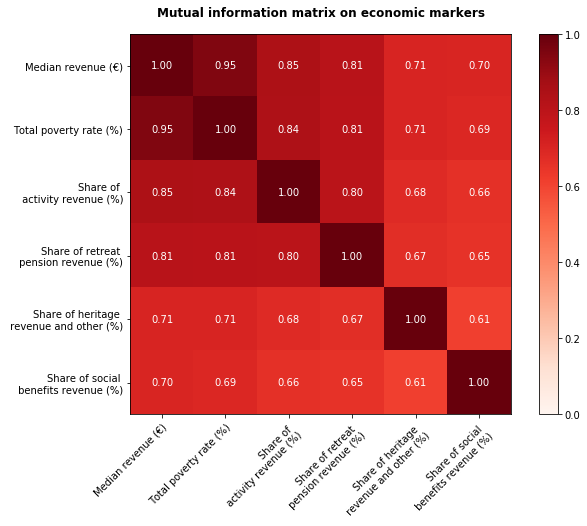

In [152]:
# We compute the mutual information for each pair of columns related to the economics of a city
mutual_info = pd.DataFrame(0, index=eco_df.columns, columns=eco_df.columns)

for (i, feat) in enumerate(eco_df.columns):
    mutual_info.loc[feat, eco_df.columns[i:]] = mutual_info_regression(eco_df[eco_df.columns[i:]], eco_df[feat])
    mutual_info.loc[feat, eco_df.columns[i:]] = mutual_info.loc[feat, eco_df.columns[i:]]/mutual_info.loc[feat,feat]
    mutual_info.loc[eco_df.columns[i:], feat] = mutual_info.loc[feat, eco_df.columns[i:]]
    
plot_cols = ['Median revenue (€)',
       'Total poverty rate (%)', 'Share of \n activity revenue (%)',
       'Share of retreat \n pension revenue (%)',
       'Share of heritage \n revenue and other (%)',
       'Share of social \n benefits revenue (%)']

# And we display it as a mutual information matrix
matrix  = np.array(mutual_info)

fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(matrix, vmin=0, vmax=1, cmap='Reds')

# We want to show all ticks...
ax.set_xticks(np.arange(len(plot_cols)))
ax.set_yticks(np.arange(len(plot_cols)))
# ... and label them with the respective list entries
ax.set_xticklabels(plot_cols)
ax.set_yticklabels(plot_cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(plot_cols)):
    for j in range(len(plot_cols)):
        string = "{0:.2f}".format(matrix[i, j])
        text = ax.text(j, i, string,
                       ha="center", va="center", color="w")

ax.set_title('Mutual information matrix on economic markers', fontweight='bold', y=1.03)
fig.colorbar(im)
plt.savefig('../docs/img/portfolio/eco_mutualinfo.pdf')
plt.show()

This matrix shows the Mutual Information that each column has with the others, normalized. Mutual Information is $1$ when the compared features are the same (i.e. when comparing a column with itself) and $0$ when the two columns do not have any common patterns.

As we can see, all columns are extremely related with each other. We do not have Mutual Information coefficients falling below $0.6$, and for most of the column pairs the MI coefficient is well above $0.7$. 

Moreover, we can also see that the ***Median revenue and Total Poverty Rate*** are the columns having the highest MI coefficients with all of the other columns. This suggests us that if we were to choose features to keep, we would be safer to keep those as they explain better all of the other features. 

However, we saw that among all these economic features, the only one having an acceptable percentage of values is Median Revenue. We decided to keep only that one in order not to loose too many information on our dataset. Since Median Revenue has high MI coefficients with all the other columns, it is safe to keep only that one because it quite embeds the information of the other economic markers.  

To sum up, and for now, this leaves us with:

* 1 column describing the food item's identifier:
    - food item index

* 11 columns describing nutritional features:
    - nutrition-score-fr_100g            
    - nutrition-score-uk_100g            
    - nutrition_grade_numeric           
    - serving_size           
    - energy_100g                        
    - fat_100g                           
    - saturated-fat_100g                 
    - proteins_100g                      
    - carbohydrates_100g                 
    - sugars_100g                        
    - fiber_100g

* 1 column describing economic features: 
    - Median revenue euros
    
* 4 columns describing geographical features
    - City
    - Arrondissement
    - Department
    - Region

In [153]:
# We keep only the wanted columns in our dataframe
dataframe = dataframe[['food_item_index', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
                       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
                       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
                       'sugars_100g', 'fiber_100g', 'cal_density', 'cal_deviation', 
                       'Median revenue euros', 'City', 'Department', 'Region', 'Arrondissement']]

## C. Mutual Information on the rest of the columns

Now that we have the important elements from the two datasets we can apply feature reduction on the nutritional columns using again Mutual Information (MI).

In [154]:
new_df = dataframe.drop(columns=['food_item_index', 'Department', 'Arrondissement', 'City', 'Region']).dropna()

mutual_info = pd.DataFrame(0, index=new_df.columns, columns=new_df.columns)

for (i, feat) in enumerate(new_df.columns):
    mutual_info.loc[feat, new_df.columns[i:]] = mutual_info_regression(new_df[new_df.columns[i:]], new_df[feat])
    mutual_info.loc[feat, new_df.columns[i:]] = mutual_info.loc[feat, new_df.columns[i:]]/mutual_info.loc[feat,feat]
    mutual_info.loc[new_df.columns[i:], feat] = mutual_info.loc[feat, new_df.columns[i:]]

mutual_info

,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,sugars_100g,fiber_100g,cal_density,cal_deviation,Median revenue euros
nutrition-score-fr_100g,1.000000,0.922832,0.438161,0.182636,0.514794,0.340843,0.340712,0.283658,0.350104,0.321641,0.249645,0.492006,0.516040,0.233291
nutrition-score-uk_100g,0.922832,1.000000,0.410812,0.188624,0.523981,0.363326,0.362016,0.294659,0.358715,0.329534,0.254940,0.495139,0.525373,0.245184
nutrition_grade_numeric,0.438161,0.410812,1.000000,0.199241,0.518880,0.349543,0.358793,0.204715,0.301677,0.295242,0.163274,0.481367,0.521050,0.314721
serving_size,0.182636,0.188624,0.199241,1.000000,0.454281,0.300983,0.274055,0.306896,0.372946,0.312811,0.242124,0.556708,0.472835,0.433935
energy_100g,0.514794,0.523981,0.518880,0.454281,1.000000,0.417581,0.366022,0.370527,0.428584,0.380727,0.301966,0.582035,0.524028,0.220636
fat_100g,0.340843,0.363326,0.349543,0.300983,0.417581,1.000000,0.442474,0.361438,0.387420,0.351667,0.271371,0.510064,0.553939,0.232154
saturated-fat_100g,0.340712,0.362016,0.358793,0.274055,0.366022,0.442474,1.000000,0.358943,0.381561,0.349674,0.274859,0.515314,0.544418,0.234969
proteins_100g,0.283658,0.294659,0.204715,0.306896,0.370527,0.361438,0.358943,1.000000,0.406548,0.374714,0.299553,0.509354,0.547630,0.254935
carbohydrates_100g,0.350104,0.358715,0.301677,0.372946,0.428584,0.387420,0.381561,0.406548,1.000000,0.464362,0.306775,0.499867,0.546703,0.270654
sugars_100g,0.321641,0.329534,0.295242,0.312811,0.380727,0.351667,0.349674,0.374714,0.464362,1.000000,0.300976,0.515032,0.536752,0.257824


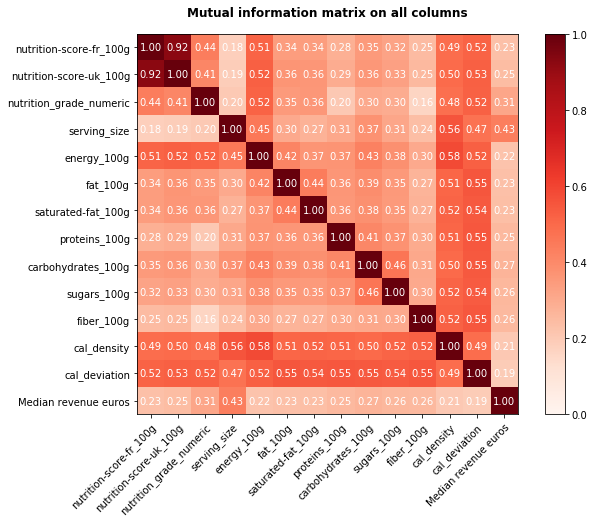

In [155]:
plot_cols = list(mutual_info.columns)

# And we display it as a mutual information matrix
matrix  = np.array(mutual_info)

fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(matrix, vmin=0, vmax=1, cmap='Reds')

# We want to show all ticks...
ax.set_xticks(np.arange(len(plot_cols)))
ax.set_yticks(np.arange(len(plot_cols)))
# ... and label them with the respective list entries
ax.set_xticklabels(plot_cols)
ax.set_yticklabels(plot_cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(plot_cols)):
    for j in range(len(plot_cols)):
        string = "{0:.2f}".format(matrix[i, j])
        text = ax.text(j, i, string,
                       ha="center", va="center", color="w")

ax.set_title('Mutual information matrix on all columns', fontweight='bold', y=1.03)
fig.colorbar(im)
plt.savefig('../docs/img/portfolio/mutualinfotot.pdf')
plt.show()

Based on the figure above, we deduce that the MI between nutrition-score-fr_100g and nutrition-score-uk_100g is very high ($0.92$). However, none of the other columns seem to have a high enough MI coefficient so as to be remved from the dataframe (they are all around or below $0.5$). This leads us to the drop of **nutrition-score-uk_100g** only. 

In [156]:
dataframe.drop(columns=['nutrition-score-uk_100g'], inplace=True)

# 6. Aggregation

First, we have to remove the DOM-TOMS since the cultural differences are too large (Guadeloupe, Guyane, etc). We have observed that given our current dataframe, we only have one product being sold in the whole region of Corsica. Since this could really affect our analysis, given that we aim at aggregating by region, we remove Corsica from the dataset.

Then, we transform the dataframe to be able to do the analysis at four different increasing levels, City, Arrondissement, Departement and Region level. For this reason, we create four different aggregations of the dataframe using each time the corresponding column.

In [157]:
# DOM-TOM Regions and Corsica
dom_tom_corse = [1, 2, 4, 94]
# DOM-TOM department
dom_tom_dep = '97'
dataframe = dataframe[dataframe['Region'].apply(lambda x: x not in dom_tom_corse)]
dataframe = dataframe[dataframe['Department'].apply(lambda x: x  != dom_tom_dep)]

In [158]:
dataframe.head()

,food_item_index,nutrition-score-fr_100g,nutrition_grade_numeric,serving_size,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,sugars_100g,fiber_100g,cal_density,cal_deviation,Median revenue euros,City,Department,Region,Arrondissement
0,359180,14.0,4,150.0,1243.0,24.0,17.0,19.0,1.3,1.3,0.0,1864.5,0.160968,18563.0,Belley,01,84,01001
1,359153,15.0,4,NaN,1402.0,30.0,19.0,15.0,1.3,1.3,NaN,NaN,0.187835,18563.0,Belley,01,84,01001
2,359177,15.0,4,NaN,1435.0,31.0,21.0,15.0,1.0,1.0,0.0,NaN,0.192079,18563.0,Belley,01,84,01001
3,359157,14.0,4,NaN,1238.0,24.0,18.0,19.0,1.0,1.0,NaN,NaN,0.163284,18563.0,Belley,01,84,01001
4,359155,15.0,4,NaN,1435.0,31.0,21.0,15.0,1.0,1.0,NaN,NaN,0.192079,18563.0,Belley,01,84,01001


This is the cleanest dataframe that we have, hence our final dataframe. We need to save it for later use.

In [ ]:
dataframe.to_csv("../data/processed/final_df.csv")

When reading it, we have to convert the geographic regions to string again and add '0' at the beginning of some geographic locations in order to make the correspondence with the geojson files later on.

In [159]:
dataframe = pd.read_csv("../data/processed/final_df.csv", low_memory=False)
dataframe = dataframe.drop(columns=['Unnamed: 0'])
dataframe['Arrondissement'] = dataframe['Arrondissement'].astype(str)
dataframe['Arrondissement'] = dataframe['Arrondissement'].apply(lambda x : '0' + x if len(x)<5 else x)
dataframe['Region'] = dataframe['Region'].apply(lambda x: str(x))
dataframe['Department'] = dataframe['Department'].apply(lambda x: str(x))
dataframe['Department'] = dataframe['Department'].apply(lambda x : '0' + x if len(x) == 1 else x)
dataframe.head()

,food_item_index,nutrition-score-fr_100g,nutrition_grade_numeric,serving_size,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,sugars_100g,fiber_100g,cal_density,cal_deviation,Median revenue euros,City,Department,Region,Arrondissement
0,431441,16.0,4,NaN,883.0,12.00,4.40,25.00,0.60,0.50,0.5,NaN,0.133987,21885.714286,Apremont,01,84,01004
1,348749,15.0,4,NaN,703.0,9.30,3.80,19.00,1.90,1.20,0.3,NaN,0.116812,21885.714286,Apremont,01,84,01004
2,348720,16.0,4,NaN,900.0,12.00,4.40,25.00,0.60,0.50,NaN,NaN,0.130923,21885.714286,Apremont,01,84,01004
3,348741,11.0,4,50.0,514.0,3.66,1.48,21.13,1.13,1.13,NaN,257.0,0.157268,21885.714286,Apremont,01,84,01004
4,348708,15.0,4,100.0,699.0,9.40,3.90,18.70,1.90,1.70,NaN,699.0,0.117324,21885.714286,Apremont,01,84,01004


In [160]:
nutritional_columns = ['nutrition-score-fr_100g', 'nutrition_grade_numeric',
                       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'proteins_100g', 
                       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'cal_deviation', 'cal_density']
economic_columns = ['Median revenue euros']
geo_columns = ['City','Department', 'Region', 'Arrondissement']

Finally, we aggregate according to each geographic subdivision. To do so, we group our dataframe by said subdivision. Each row will be a geographic location and the columns are chosen to be the median of the features for each location.

In [161]:
def aggregate(df, area_column):
    """Aggregate our nutritional data per geographic area
    
    Arguments:
    ----------
    df: pandas.DataFrame
        Dataframe containing the relevant information.
    area_column: string
        Name of the column coding the geographic area.
    
    Returns:
    ---------
    median_df: pandas.Dataframe
        Dataframe conatining the median value for each nutritional feature, grouped by geographic area.
    """
    drop_cols = geo_columns.copy()
    drop_cols.remove(area_column)
    
    median_df = df.drop(columns=drop_cols).dropna().groupby(area_column).median()
    
    return median_df

In [162]:
aggregated_city = aggregate(dataframe, 'City') 
aggregated_arrondissement = aggregate(dataframe, 'Arrondissement') 
aggregated_department = aggregate(dataframe, 'Department') 
aggregated_region = aggregate(dataframe, 'Region') 

# 7. Clustering

We created a dataframe per geographic level, that aggregates by median.

**1. Cities**

In [ ]:
def plot_scatter(df):
    """Display the scatter plots representing the relationship between each nutrition attribute 
    and the Median Revenue
    
    Arguments:
    ----------
    df: pandas.DataFrame
        Dataframe containing the relevant information.
    """
    fig, axs = plt.subplots(3, 4, figsize=(25, 18))
    fig.suptitle("Scatter plots of the relationships between each nutrition attribute and the Median Revenue", 
                fontweight="bold")
    i = 0;
    j = 0;
    count = 1;
    for col in nutritional_columns:
        df.plot.scatter(x='Median revenue euros', y=col, ax=axs[i, j])
        axs[i, j].set_title(col)
        if count % 4 == 0:
            i = i + 1;
        j = (j + 1) % 4;
        count = count + 1
    fig.show()

In [ ]:
plot_scatter(aggregated_city)

Here we cannot see clear clusters, especially not across different median revenues. The datapoints are all concentrated around 20000 €, and we can see some vague clusters for the graph plotting the **carbohydrates** against **median revenue** (plot (2,4)). The clusters are however not differentiated according to median revenue.

**2. Arrondissements**

In [ ]:
plot_scatter(aggregated_arrondissement)

Same as above, no clear clusters emerge from these scatter plots.

**3. Departments**

In [ ]:
plot_scatter(aggregated_department)

Once again, all blobs are concentrated around 20000€ and we cannot extract actual clusters.

**4. Regions**

In [ ]:
plot_scatter(aggregated_region)

Here, we cannot find clusters but we might get a hint of some correlations. These links are explored below. 

In order to make sure that no good clusters can be found, we used DBSCAN with several parameters. We plotted only the results for **nutritional score** against **median revenue** since it was the most significant plot.

In [138]:
def cluster(df, eps=0.3, min_samples=10):
    """Compute and display clusters
    
    Arguments:
    ----------
    df: pandas.DataFrame
        Dataframe containing the needed information.
    eps: float
        Distance to consider for neighbors for the DBSCAN algorithm.
    min_samples: int
        Minimum number of points to consider the set of points as a cluster and no outliers.
    
    Returns:
    ---------
    labels: numpy.ndarray
        The labels associated with each point.
    """
    X = StandardScaler().fit_transform(df)

    # Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    if n_clusters_ > 0:
        print("Silhouette Coefficient: %0.3f"
              % metrics.silhouette_score(X, labels))
    else:
        print("Silhouette Coefficient could not be computed for 0 clusters")

    # Plot result
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    plt.figure(figsize=(10,7))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    return labels

In [ ]:
labels = cluster(aggregated_city[['Median revenue euros', 'nutrition-score-fr_100g']], 2, 3)

In [ ]:
labels = cluster(aggregated_arrondissement[['Median revenue euros', 'nutrition-score-fr_100g']], 3, 10)

In [ ]:
labels = cluster(aggregated_department[['Median revenue euros', 'nutrition-score-fr_100g']], 3, 2)

In [ ]:
labels = cluster(aggregated_region[['Median revenue euros', 'energy_100g']], 0.7, 3)

As predicted above, the maximum Silhouette coefficient is always found for one cluster. There are no meaningful distinct clusters.

These are just examples. We tested the clustering in two dimensions for each nutritional feature, for each geographical location, without finding any meaningful clusters.

# Spectral clustering

In multivariate statistics and the clustering of data, spectral clustering techniques make use of the spectrum (eigenvalues) of the similarity matrix of the data to perform dimensionality reduction before clustering in fewer dimensions. 

This technique relies in the representation of data as a graph. A graph is composed of nodes linked together by edges. The nodes usually represent a data point, and the edges between the nodes are a measure of the similarity of those nodes. 

The similarity matrix in graph theory is usually an adjacency matrix $A$(weighted or not). This adjacency matrix consists in a square matrix, having as rows and columns the number of nodes $N $in the graph. The values of each matrix entry represent the edge weight, i.e.: 

$ A[i,j] = w_{ij}$ is the edge weight between node $i$ and node $j$.

In order to construct our graph, we go back to our original dataframe before it was aggregated. We consider our nodes to be each food item, and the edges are the nutritional similarity between those nodes. 

We decided to compute the adjacency matrix only with the nutritional features and to leave the economic marker (i.e. median revenue) as a label. The aim of this analysis is to check if products are clustered by some "healthiness" measure and if so, the "healthier" clusters are associated with higher revenues.

In [79]:
import networkx as nx
from scipy.sparse import csgraph
import scipy.sparse.linalg

In [73]:
def compute_adjacency(matrix_df):
    
    adjacency = np.zeros((matrix_df.shape[0], matrix_df.shape[0]))
    for i in range(matrix_df.shape[1]):
        distance = np.abs(matrix_df[:,i].reshape(-1, 1) - matrix_df[:,i])
        distance = distance/np.max(distance)
        
        adjacency = adjacency + distance

    adjacency = np.max(adjacency) - adjacency
    np.fill_diagonal(adjacency, 0)
    return adjacency/np.max(adjacency)

In [78]:
nutri_df = dataframe.copy().dropna()
adjacency = compute_adjacency(nutri_df[nutritional_columns].values)
n_nodes =  len(adjacency)

In [85]:
sparsity = (n_nodes*n_nodes - np.count_nonzero(adjacency))*100/(n_nodes*n_nodes)
print('Sparsity: {spars:.3f}%'.format(spars=sparsity))

Sparsity: 0.015%


Since our network is not sparse at all (i.e. all nodes are connected to each other) we decided to keep only the 300 strongest connections for each node for computational purposes. This makes our graph sparser and not much information is lost by the fact that it is not fully connected anymore.

In [81]:
sparse_adjacency = np.zeros(adjacency.shape)

for i in range(adjacency.shape[0]):
    thresh = np.sort(adjacency[i,:])[adjacency.shape[0] - 300 - 1]
    idx = adjacency[i,:] > thresh
    sparse_adjacency[i,idx] = adjacency[i,idx]
n_nodes =  len(sparse_adjacency)

In [86]:
sparsity = (n_nodes*n_nodes - np.count_nonzero(sparse_adjacency))*100/(n_nodes*n_nodes)
print('Sparsity: {spars:.3f}%'.format(spars=sparsity))

Sparsity: 95.498%


In [83]:
G_s = nx.from_numpy_matrix(sparse_adjacency)
laplacian_s = sparse.csgraph.laplacian(sparse_adjacency, normed=True)

# We compute ordered eigenvalues e and graph Fourier basis U with eigh
e_s , U_s = scipy.linalg.eigh(laplacian_s)
coords_s = U_s[:,1:3]

In [87]:
print(nx.is_connected(G_s))

True


Graph is connected, yay! We can embed it using Laplacian eigenmaps.

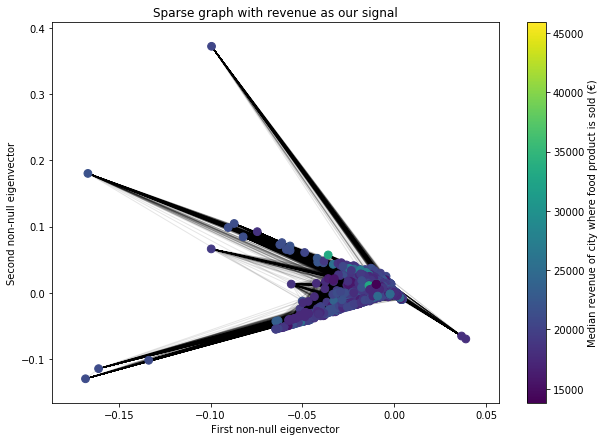

In [140]:
rev_sig = nutri_df['Median revenue euros'].values

plt.figure(figsize = (10,7))
nodes = nx.draw_networkx_nodes(G_s, coords_s, node_size=60, node_color = rev_sig)
nx.draw_networkx_edges(G_s, coords_s, alpha=0.1)
plt.title("Sparse graph with revenue as our signal")
plt.xlabel("First non-null eigenvector")
plt.ylabel("Second non-null eigenvector")
plt.colorbar(nodes, label='Median revenue of city where food product is sold (€)')
plt.savefig("../docs/img/portfolio/graph.pdf")
plt.show()

Now we can try clustering with DBSCAN

Estimated number of clusters: 1
Estimated number of noise points: 12
Silhouette Coefficient: 0.909


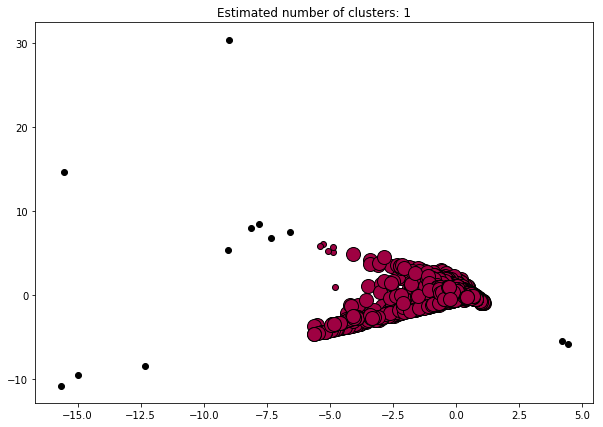

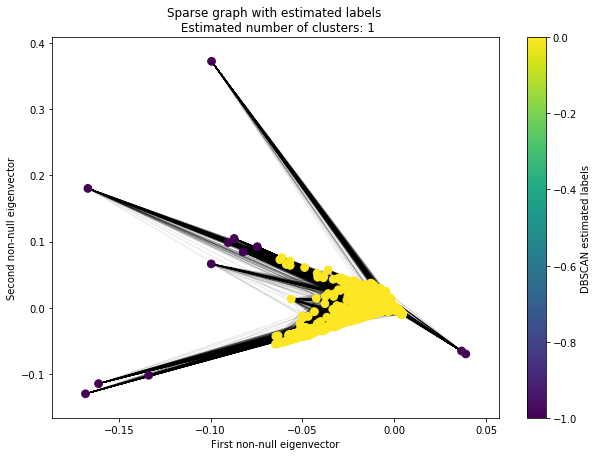

In [141]:
labels = cluster(coords_s, eps=2, min_samples=10)

plt.figure(figsize=(10,7))
nodes = nx.draw_networkx_nodes(G_s, coords_s, node_size=60, node_color=labels)
nx.draw_networkx_edges(G_s, coords_s, alpha=0.1)
plt.title('Sparse graph with estimated labels \n Estimated number of clusters: 1')
plt.xlabel("First non-null eigenvector")
plt.ylabel("Second non-null eigenvector")
plt.colorbar(nodes, label='DBSCAN estimated labels')
plt.savefig("../docs/img/portfolio/labels_graph.pdf")
plt.show()

As we can see, we can find no clear cluster. Our graph is indeed fully connected, but most points are agglomerated into one big cluster, with a few food items spiking out. This is confirmed by the results of the DBSCAN clustering, which has a maximum Silhouette Coefficient when finding only one cluster. 

Our food products are hence extremely similar among all of them. They all have the same nutritional features and this is why cannot find more than one cluster. 

# 8. Correlation analysis 

In light of our clear lack of good clusters, we now want to see if there are 

In [163]:
corr_cols = ['nutrition-score-fr_100g', 'nutrition_grade_numeric','energy_100g', 'fat_100g', 
             'saturated-fat_100g', 'proteins_100g','fiber_100g', 'carbohydrates_100g', 
             'sugars_100g', 'cal_density', 'cal_deviation','Median revenue euros']
corr_names = ['Nutrition score', 'Nutrition grade \n(numeric)',
              'Energy \n (per 100 g)', 'Fat \n (per 100 g)', 'Saturated fat \n (per 100g)', 
              'Proteins \n (per 100g)','Fiber (per 100g)', 'Carbohydrates \n (per 100 g)', 
              'Sugars \n(per 100g)', 'Calory density', 'Calory deviation','Median revenue (€)']

In [164]:
def plot_corr_matrix(df, geography):
    """Display the correlation matrix for medians for a geographic area
    
    Arguments:
    ----------
    df: pandas.DataFrame
        Dataframe containing the values of the medians for each feature, grouped by geographic area.
    geography: string
        Name of the type of geographic area considered.
    """
    corr = np.array(df[corr_cols].corr())
    names = corr_names

    fig, ax = plt.subplots(figsize=(12, 9))
    im = ax.imshow(corr, vmin=-1, vmax=1, cmap='bwr', alpha=0.5)


    # We want to show all ticks...
    ax.set_xticks(np.arange(len(names)))
    ax.set_yticks(np.arange(len(names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    df_corr = df[corr_cols]
    columns = df_corr.columns

    for i in range(len(names)):
        for j in range(len(names)):
            string = "{0:.2f}".format(corr[i, j])
            if (j == 11 and i != 11):
                r, p = stats.pearsonr(df_corr[columns[i]], df_corr['Median revenue euros'])
                
                if p < 0.05:
                    text = ax.text(j, i, string,
                                   ha="center", va="center", color='black', fontweight='bold')
                else: 
                    text = ax.text(j, i, string, ha="center", va="center", color="w")
                        
            else:
                text = ax.text(j, i, string, ha="center", va="center", color="w")

    fig.colorbar(im)
    ax.set_title("Correlation matrix for median aggregated values by " + geography, y=1.03, fontweight="bold")
    plt.show()

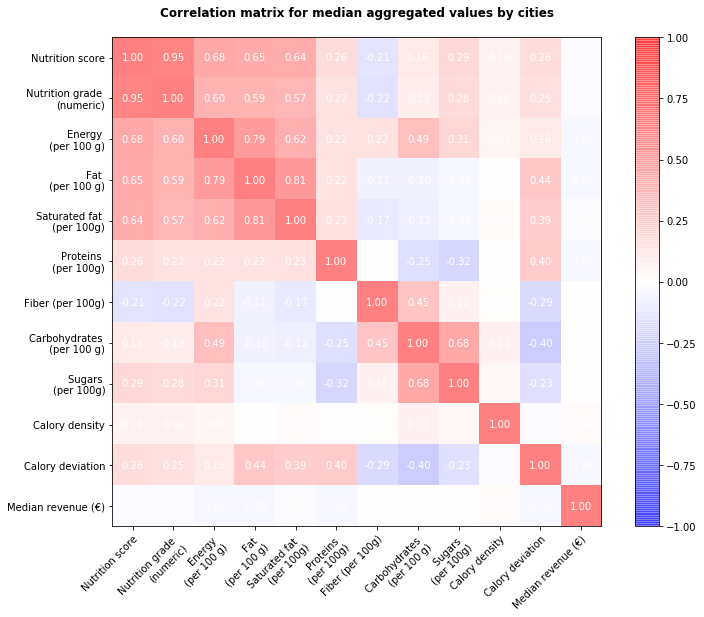

In [165]:
plot_corr_matrix(aggregated_city, "cities")

At a city level, we cannot see much from the correlation matrix. The only correlations that we find are among nutritional features, e.g. the nutrition score and grade (high when unhealthy, low when healthy) is positively correlated with energy, sugars, fat and negatively correlated with fiber. 

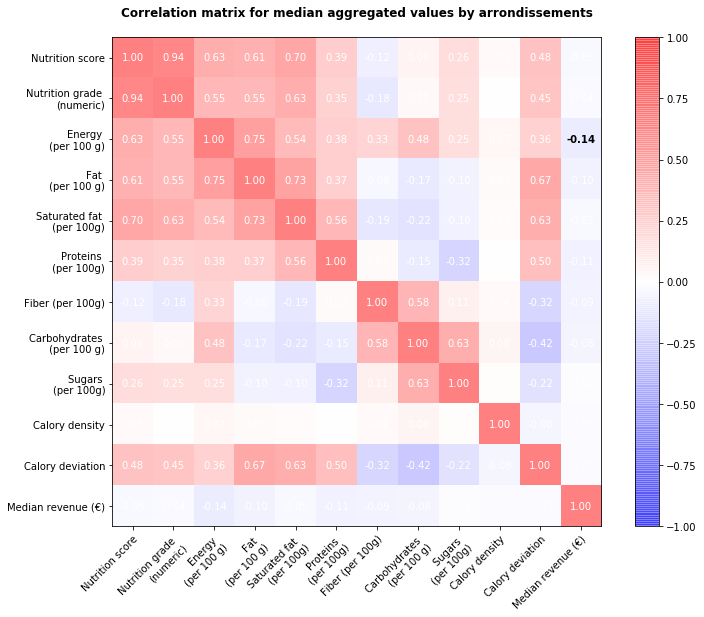

In [166]:
plot_corr_matrix(aggregated_arrondissement, "arrondissements")

At the arrondissement level, we can also mostly see the correlations between nutritional features. We can however see that the correlation between nutritional score and median revenue is negative, according to the colorbar. 

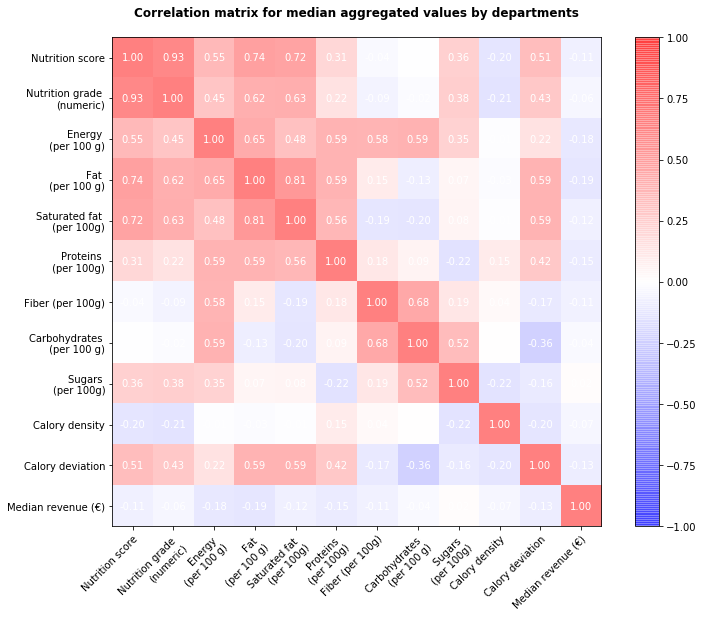

In [167]:
plot_corr_matrix(aggregated_department, "departments")

At the Department level (second largest subdivision of the French territory), the correlations between the nutritional features are more accentuated, especially between nutrition score and fat and saturated fat. We can see that the median revenue column (the last column) has is positively correlated to the nutrition grade, but negatively to the calory density.

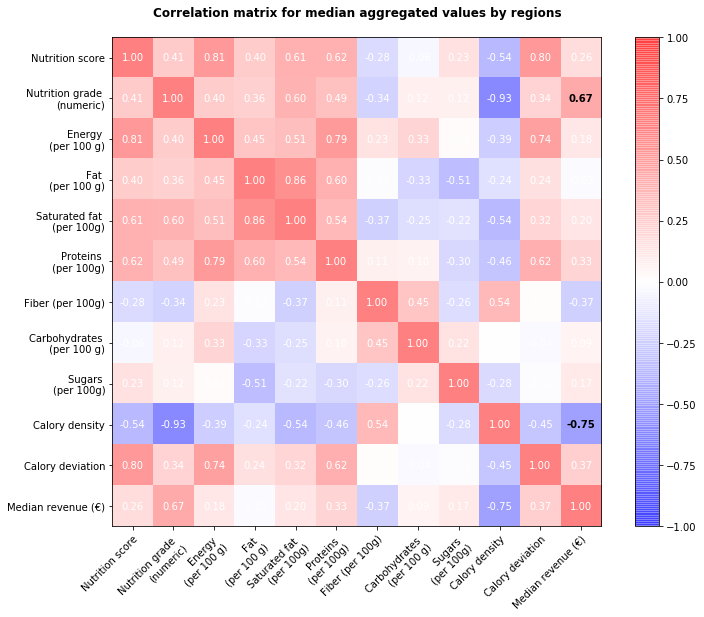

In [168]:
plot_corr_matrix(aggregated_region, "regions")

Hooray, we found something at the arrondissement and region levels!

Now we can see that the Median revenue column (the last column) has a strong negative correlation with most of the nutritional features: nutrition score, nutrition grade, serving size, energy, fat, saturated fat, sugars, carbohydrates and calory density. This might indicate that the poorer the region, the worse the quality of the available products. This is reinforced by the fact that the Median revenue is positively correlated with the proteins and fiber (richer regions have more available products that have proteins and fibers).

Let's see more closely how significant these correlations are:

In [169]:
def pearson_pval_df(df):
    """Compute and display the Pearson coefficient and the p-value between the median revenue
    and each nutritional feature
    
    A line displayed in red means that the correlation is not significant.
    A line displayed in green means that the  correlation is significant.
    
    Arguments:
    ----------
    df: pandas.DataFrame
        Dataframe containing the values for each feature, aggregated by geographic area.
    """
    print('Linear correlation between Median revenue and each of the nutritional columns')
    for col in nutritional_columns:
        r, p = stats.pearsonr(df[col], df['Median revenue euros'])
        if p < 0.05:
            color = 'green'
        else:
            color = 'red'
        print(colored('{:<40}{:<16}{:<28.3f}{:<10}{:<30.3f}'.format(col, 'Pearson coeff', r, 'p-value', p), color))

    print('\n')

In [170]:
pearson_pval_df(aggregated_region)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   0.263                       p-value   0.410                         
nutrition_grade_numeric                 Pearson coeff   0.671                       p-value   0.017                         
energy_100g                             Pearson coeff   0.183                       p-value   0.569                         
fat_100g                                Pearson coeff   -0.026                      p-value   0.935                         
saturated-fat_100g                      Pearson coeff   0.198                       p-value   0.538                         
proteins_100g                           Pearson coeff   0.332                       p-value   0.292                         
carbohydrates_100g                      Pearson coeff   0.091                       p-value   0.778                         
sugars_100g                             Pearson

From the mean dataframe, the columns for which the correlation with the Median revenue is significant (i.e. the corresponding p-value is below 0.05) are:
      
* nutrition_grade_numeric
* cal_density          

We have a negative correlation between the calory density column and the mean median revenue for the overall regions. The Pearson coefficient is below the -0.3 threshold , which allows us to claim that there is a correlation. It is actually a very significant correlation since the coefficient is strongly negative (-0.748).
This might indicate that in poor regions, the food items that are available might have more calories per serving.

However, we also have a very significant (p-value = 0.017) **positive** correlation between the Nutrition Grade and the Median revenue. Since the nutrition grade is higher for unhealthier products, this could indicate that wealthier regions have unhealthier available products. 

A closer look to this metric shows us that the correlation is meaningless. Indeed, the median nutrition grade for each region is **constantly 3 except for one where it is 2**. This result is hence not exploitable.

Here is a scatter plot showing the most significant correlation that we found.

<Figure size 432x288 with 0 Axes>

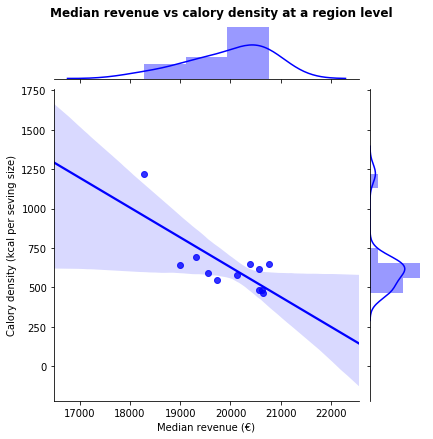

In [178]:
plt.figure()
fig = sns.jointplot(x=aggregated_region['Median revenue euros'], y=aggregated_region['cal_density'], kind="reg", color='b')
fig.fig.suptitle("""Median revenue vs calory density at a region level""", y=1.01,
                 fontweight="bold"
                )
plt.xlabel("Median revenue (€)")
plt.ylabel("Calory density (kcal per seving size)")
plt.savefig('../docs/img/portfolio/corr_thumb.pdf', bbox_inches="tight")
plt.show()

In [172]:
pearson_pval_df(aggregated_arrondissement)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.049                      p-value   0.448                         
nutrition_grade_numeric                 Pearson coeff   -0.039                      p-value   0.539                         
energy_100g                             Pearson coeff   -0.144                      p-value   0.024                         
fat_100g                                Pearson coeff   -0.095                      p-value   0.135                         
saturated-fat_100g                      Pearson coeff   -0.053                      p-value   0.411                         
proteins_100g                           Pearson coeff   -0.107                      p-value   0.092                         
carbohydrates_100g                      Pearson coeff   -0.081                      p-value   0.205                         
sugars_100g                             Pearson

At an arrondissement level, we find a negative relationship between energy and median revenue. It is the only relationship that is significant since its p-value falls below the 0.05 threshold.

This might indicate that poor regions could be prone to buying products that are more caloric than wealthier regions, which goes in the direction of our thesis.

<Figure size 432x288 with 0 Axes>

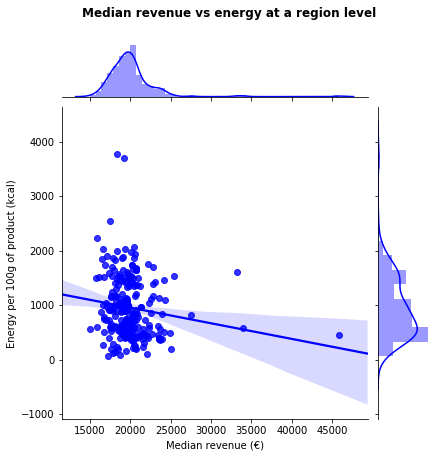

In [179]:
plt.figure()
fig = sns.jointplot(x=aggregated_arrondissement['Median revenue euros'], y=aggregated_arrondissement['energy_100g'], kind="reg", color='b')
fig.fig.suptitle("""Median revenue vs energy at a region level""",
                 y=1.05,
                 fontweight="bold"
                )
plt.xlabel("Median revenue (€)")
plt.ylabel("Energy per 100g of product (kcal)")
plt.savefig("../docs/img/portfolio/corr_thumb.pdf", bbox_inches="tight")
plt.show()

# 9. Geographic visualization

In order to make Folium maps, we need to reset the index.

In [ ]:
aggregated_arrondissement_med = aggregated_arrondissement.reset_index()
aggregated_department_med = aggregated_department.reset_index()
aggregated_region_med = aggregated_region.reset_index()

This is an auxiliary function that creates an overlay and deals with missing values. 

In [ ]:
def other_choropleth(df, col_property, geojson, territory, legend_name, fill_color='OrRd', legend_step=6):
    map_data = df.copy()

    map_dict = map_data.set_index(territory)[col_property].to_dict()
    
    min_data = np.min(map_data[col_property])
    max_data = np.max(map_data[col_property])
    scale = list(np.linspace(min_data, max_data, legend_step))
    color_range = color_brewer(fill_color, n=legend_step-1)

    color_scale = StepColormap(color_range, vmin=min_data, vmax=max_data, index=scale, caption=legend_name)

    def get_color(feature):
        value = map_dict.get(feature['properties']['code'])
        if value is None:
            return '#8c8c8c' # MISSING -> gray
        else:
            return color_scale(value)

    m = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)

    folium.GeoJson(
        data = geojson,
        style_function = lambda feature: {
            'fillColor': get_color(feature),
            'fillOpacity': 0.7,
            'color' : 'black',
            'weight' : 0.5,  
        }    
    ).add_to(m)
    
    m.add_child(color_scale)
    
    return m

Borders

In [ ]:
# geojson: https://github.com/gregoiredavid/france-geojson
arr_borders = json.load(open("../data/raw/arrondissements.geojson"))
reg_borders = json.load(open("../data/raw/regions.geojson"))
dep_borders = json.load(open("../data/raw/departements.geojson"))

**1. Arrondissements**

In [ ]:
map_revenue_arr = other_choropleth(aggregated_arrondissement_med, 'Median revenue euros', 
                                   arr_borders, 'Arrondissement', 'Median revenue (€)', fill_color='OrRd_r')
map_revenue_arr.save("../data/processed/map_{}.html".format('med_rev_arr'))
display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format('med_rev_arr')))
map_revenue_arr

In [ ]:
map_energy_arr = other_choropleth(aggregated_arrondissement_med, 'energy_100g', arr_borders, 'Arrondissement', 'Energy per 100 g (in kJ)')
map_energy_arr.save("../data/processed/map_{}.html".format('med_energy_arr'))
display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format('med_energy_arr')))
map_energy_arr

**2. Regions**

In [ ]:
map_revenue_reg = other_choropleth(aggregated_region_med, 'Median revenue euros', reg_borders, 'Region', 'Median revenue (€)', fill_color='OrRd_r',legend_step=6)
map_revenue_reg.save("../data/processed/map_{}.html".format('med_rev_reg'))
display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format('med_rev_reg')))
map_revenue_reg

In [ ]:
map_calden_reg = other_choropleth(aggregated_region_med, 'cal_density', reg_borders, 'Region', 'Calory density', legend_step=6)
map_calden_reg.save("../data/processed/map_{}.html".format('med_cd_reg'))
display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format('med_cd_reg')))
map_calden_reg

In [ ]:
map_nutri_reg = other_choropleth(aggregated_region_med, 'nutrition_grade_numeric', reg_borders, 'Region', 'Nutrition grade', legend_step=6)
map_nutri_reg.save("../data/processed/map_{}.html".format('med_nutri_reg'))
display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format('med_nutri_reg')))
map_nutri_reg

# 10. Interactive Maps

In [ ]:
from bokeh.io import show, output_notebook
from bokeh.models import GeoJSONDataSource, HoverTool, LogColorMapper, LinearColorMapper, BasicTicker, ColorBar
from bokeh.plotting import figure, output_file
from bokeh.palettes import Viridis256, OrRd
import pickle
from bokeh.transform import linear_cmap
from copy import deepcopy

In [ ]:
geo_src_dict = json.load(open('../data/raw/regions.geojson'))

for (i,feature) in enumerate(geo_src_dict['features']):
    if (aggregated_region_med['Region']==feature['properties']['code']).any() == True:
        feature['properties']['median_revenue'] = aggregated_region_med[aggregated_region_med['Region']==feature['properties']['code']]["Median revenue euros"].values[0]
        feature['properties']['energy_100g'] = aggregated_region_med[aggregated_region_med['Region']==feature['properties']['code']]["energy_100g"].values[0]
    
with open('../data/raw/departements_dict.geojson', 'w', encoding='utf-8') as fp:
    json.dump(geo_src_dict, fp)

with open('../data/raw/departements_dict.geojson', encoding='utf-8') as f:
    geo_src = GeoJSONDataSource(geojson=f.read())

In [ ]:
geo_src_dict

In [ ]:
with open('../data/raw/departements_dict.geojson', encoding='utf-8') as f:
    geo_src = GeoJSONDataSource(geojson=f.read())
    
TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"

p = figure(title='France Regions', tools=TOOLS, x_axis_location=None, y_axis_location=None, width=900, height=900)
p.grid.grid_line_color = None

cmap = LinearColorMapper(palette=OrRd[5], low=np.min(aggregated_region_med['Median revenue euros']), high=np.max(aggregated_region_med['Median revenue euros']))

p.patches('xs', 'ys', fill_alpha=0.7, fill_color={'field': 'median_revenue', 'transform': cmap},
         line_color='black', line_width=0.5, source=geo_src)

hover = p.select_one(HoverTool)
hover.point_policy = 'follow_mouse'
hover.tooltips = [('Departement:', '@nom'), ('Median Revenue:', '@median_revenue{int} €')]


color_bar = ColorBar(color_mapper=cmap, ticker= BasicTicker(),
                     location=(0,0))

p.add_layout(color_bar, 'right')
output_file('France_Regions.html')

show(p)

In [ ]:
with open('../data/raw/departements_dict.geojson', encoding='utf-8') as f:
    geo_src = GeoJSONDataSource(geojson=f.read())
    
TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"

p = figure(title='France Regions', tools=TOOLS, x_axis_location=None, y_axis_location=None, width=900, height=900)
p.grid.grid_line_color = None

cmap = LinearColorMapper(palette=OrRd[5], low=np.min(aggregated_region_med['energy_100g']), high=np.max(aggregated_region_med['energy_100g']))

p.patches('xs', 'ys', fill_alpha=0.7, fill_color={'field': 'energy_100g', 'transform': cmap},
         line_color='black', line_width=0.5, source=geo_src)

hover = p.select_one(HoverTool)
hover.point_policy = 'follow_mouse'
hover.tooltips = [('Departement:', '@nom'), ('energy:', '@energy_100g{int} KJ')]


color_bar = ColorBar(color_mapper=cmap, ticker= BasicTicker(),
                     location=(0,0))

p.add_layout(color_bar, 'right')
output_file('France_Regions.html')

show(p)

In [ ]:
from bokeh.palettes import OrRd, YlOrRd as palette  #Spectral6 as palette
from bokeh.plotting import figure, save, show
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, LogColorMapper, CustomJS, Slider, Toggle, Select
import geopandas as gpd
import pysal as ps
import numpy as np
import pandas as pd
import fiona
import numpy as np
from bokeh.io import show, output_file
from bokeh.palettes import Reds6 as palette
from bokeh.resources import CDN
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon
from shapely.prepared import prep
from bokeh.layouts import column, row, widgetbox

In [ ]:
def getXYCoords(geometry, coord_type):
    """ Returns either x or y coordinates from  geometry coordinate sequence. Used with LineString and Polygon geometries."""
    if coord_type == 'x':
        return [x[0] for x in geometry]
    elif coord_type == 'y':
        return [x[1] for x in geometry]

def getPolyCoords(geometry, coord_type):
    """ Returns Coordinates of Polygon using the Exterior of the Polygon."""
    ext = geometry['coordinates'][0]
    return getXYCoords(ext, coord_type)

def getLineCoords(geometry, coord_type):
    """ Returns Coordinates of Linestring object."""
    return getXYCoords(geometry, coord_type)

def getPointCoords(geometry, coord_type):
    """ Returns Coordinates of Point object."""
    if coord_type == 'x':
        return geometry[0]
    elif coord_type == 'y':
        return geometry[1]

def multiGeomHandler(multi_geometry, coord_type, geom_type):
    """
    Function for handling multi-geometries. Can be MultiPoint, MultiLineString or MultiPolygon.
    Returns a list of coordinates where all parts of Multi-geometries are merged into a single list.
    Individual geometries are separated with np.nan which is how Bokeh wants them.
    # Bokeh documentation regarding the Multi-geometry issues can be found here (it is an open issue)
    # https://github.com/bokeh/bokeh/issues/2321
    """

    for i, part in enumerate(multi_geometry["coordinates"]):
        # On the first part of the Multi-geometry initialize the coord_array (np.array)
        if i == 0:
            coord_arrays = getXYCoords(part[0], coord_type)
            max_length = len(part[0])
        else:
            if len(part[0]) > max_length:
                max_length = len(part[0])
                coord_arrays = getXYCoords(part[0], coord_type)
    # Return the coordinates
    return coord_arrays


def getCoords(row, geom_col, coord_type):
    """
    Returns coordinates ('x' or 'y') of a geometry (Point, LineString or Polygon) as a list (if geometry is LineString or Polygon).
    Can handle also MultiGeometries.
    """
    # Get geometry
    geom = row[geom_col]

    # Check the geometry type
    gtype = geom["type"]

    # "Normal" geometries
    # -------------------

    if gtype == "Point":
        return getPointCoords(geom, coord_type)
    elif gtype == "LineString":
        return list( getLineCoords(geom, coord_type) )
    elif gtype == "Polygon":
        return list( getPolyCoords(geom, coord_type) )

    # Multi geometries
    # ----------------

    else:
        return list( multiGeomHandler(geom, coord_type, gtype) )

In [ ]:
def create_args_for_maps(area_name, column_name):
    geojson_file_name = "../data/raw/{}s.geojson".format(area_name.lower())
    # create dataframe
    data = gpd.read_file(geojson_file_name, encoding='utf-8')
    df = aggregate(dataframe, column_name)
    df.reset_index(inplace=True)
    joined_df = data.merge(df, left_on="code", right_on=column_name, how="left")
    joined_df.drop(columns={"geometry", "code", "food_item_index", column_name}, inplace=True)
    
    # get x and y for contour of the areas
    borders = json.load(open(geojson_file_name))
    areas_x = [getCoords(i, geom_col="geometry", coord_type="x") for i in borders['features']]
    areas_y = [getCoords(i, geom_col="geometry", coord_type="y") for i in borders['features']]
    
    # create dict for arguments
    arguments = {"{}_x".format(column_name.lower()): areas_x, "{}_y".format(column_name.lower()): areas_y,}
    for column in joined_df.columns:
         arguments["{}_{}".format(column_name.lower(), column)] = joined_df[column].values
    return arguments

In [ ]:
def create_datasources_for_map():
    datasources = {}
    for area_name, column_name in [("Arrondissement", "Arrondissement"), 
                                   ("Departement", "Department"), 
                                   ("Region", "Region")
                                  ]:
        args = create_args_for_maps(area_name, column_name)
        args['x'] = args['{}_x'.format(column_name.lower())]
        args['y'] = args['{}_y'.format(column_name.lower())]
        args['name'] = args['{}_nom'.format(column_name.lower())]
        datasources[column_name.lower()] = ColumnDataSource(args)
    return datasources

In [ ]:
sources = create_datasources_for_map()

In [ ]:
def create_map():
    # initial values
    low = np.min(aggregated_department_med['nutrition_grade_numeric'])
    high = np.max(aggregated_department_med['nutrition_grade_numeric'])
    source = sources['department']
    display_name = "Nutrition grade"
    display_column = "nutrition_grade_numeric"
    area_name = "Department"
    area_column = "department"
    source.data['display'] = source.data["{}_{}".format(area_column, display_column)]
    TOOLS = "pan,wheel_zoom,hover"
    
    # color mapper
    cmap = LinearColorMapper(palette=OrRd[5], low=low, 
                             high=high)

    p = figure(
        title="Geographical distribution of the nutrition grade", tools=TOOLS,
        x_axis_location=None, y_axis_location=None
    )
    p.grid.grid_line_color = None
    p.patches('x', 'y', source=source,
              fill_color={'field': 'display', 'transform': cmap},
              fill_alpha=0.8, line_color="black", line_width=0.3)
    
    color_bar = ColorBar(color_mapper=cmap, ticker=BasicTicker(), location=(0, 0))
    p.add_layout(color_bar, 'right')

    # hover behavior
    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [(area_name, "@name"),(display_name, "@display"), ("(Long, Lat)", "($x, $y)")]
    
    # interactions
    callback_values = CustomJS(args=dict(p=p, display_name=display_name, area_name=area_name,
                                     display_column=display_column, area_column=area_column,
                                     hover=hover, cmap=cmap, source=source, sources=sources), code="""
         display_column = cb_obj.value;
         let j = `${area_column}_${display_column}`
         for(let option of cb_obj.options) {
             if(option[0] == display_column) {
                 display_name = option[1]
             }
         }
         p.title.text = `Geographical distribution of the ${display_name}`;
         hover.tooltips = [[area_name, "@name"], [display_name, "@display"],
                           ["(Long, Lat)", "($x, $y)"]]
         let details = sources[area_column].data[j]
         cmap.low = Math.min(...details.filter(x => !isNaN(x)))
         cmap.high = Math.max(...details.filter(x => !isNaN(x)))
         source.data['display'] = details;
         callback_areas.args['hover'] = hover
         callback_areas.args['cmap'] = cmap
         callback_areas.args['display_name'] = display_name
         callback_areas.args['display_column'] = display_column
         callback_areas.args['area_name'] = area_name
         callback_areas.args['area_column'] = area_column
         callback_areas.args['source'] = source
         callback_areas.args['p'] = p

         this.callback.args['hover'] = hover
         this.callback.args['cmap'] = cmap
         this.callback.args['display_name'] = display_name
         this.callback.args['display_column'] = display_column
         this.callback.args['area_name'] = area_name
         this.callback.args['area_column'] = area_column
         this.callback.args['source'] = source
         this.callback.args['p'] = p
         source.change.emit();
        """)
    value_selection = Select(title="Value:", value="nutrition_grade_numeric",
                         options=[("Median revenue euros", "Median revenue"), 
                                  ("nutrition_grade_numeric", "Nutrition grade")],
                         callback=callback_values,
                        )
    callback_areas = CustomJS(args=dict(p=p, display_name=display_name, area_name=area_name,
                                        display_column=display_column, area_column=area_column,
                                        hover=hover, cmap=cmap, source=source, sources=sources), code="""
             area_column = cb_obj.value;
             let j = `${area_column}_${display_column}`
             console.log(j)
             for(let option of cb_obj.options) {
                 if(option[0] == area_column) {
                     area_name = option[1]
                 }
             }
             hover.tooltips = [[area_name, "@name"], [display_name, "@display"],
                               ["(Long, Lat)", "($x, $y)"]]
             let details = sources[area_column].data[j]
             cmap.low = Math.min(...details.filter(x => !isNaN(x)))
             cmap.high = Math.max(...details.filter(x => !isNaN(x)))
             console.log(`${area_column}_x`)
             source.data['x'] = sources[area_column].data[`${area_column}_x`]
             source.data['y'] = sources[area_column].data[`${area_column}_y`]
             source.data['name'] = sources[area_column].data[`${area_column}_nom`]
             source.data['display'] = details
             
             callback_values.args['hover'] = hover
             callback_values.args['cmap'] = cmap
             callback_values.args['display_name'] = display_name
             callback_values.args['display_column'] = display_column
             callback_values.args['area_name'] = area_name
             callback_values.args['area_column'] = area_column
             callback_values.args['source'] = source
             callback_values.args['p'] = p
             
             this.callback.args['hover'] = hover
             this.callback.args['cmap'] = cmap
             this.callback.args['display_name'] = display_name
             this.callback.args['display_column'] = display_column
             this.callback.args['area_name'] = area_name
             this.callback.args['area_column'] = area_column
             this.callback.args['source'] = source
             this.callback.args['p'] = p
             
             source.change.emit();
            """)
    area_selection = Select(title="Area:", value="department",
                             options=[("region", "Region"), ("department", "Department")],
                             callback=callback_areas,
                            )
    callback_values.args['callback_areas'] = callback_areas
    callback_areas.args['callback_values'] = callback_values

    # display map
    show(column(widgetbox(area_selection),widgetbox(value_selection),p,))

In [ ]:
create_map()